In [17]:
from __future__ import division, print_function

import json
import numpy as np
import os
import string

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from glob import iglob
from scipy.sparse.linalg import svds
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

In [2]:
def load_reviews():
    reviews = defaultdict(list)
    for filename in iglob("data/reviews/*.json"):
        with open(filename) as f:
            loaded = json.load(f)
            if len(loaded) == 250:
                for review in loaded:
                    reviews[review["app_id"]].append(review)
    return reviews

In [3]:
reviews = load_reviews()

app_ids = np.array(reviews.keys())
app_ids.sort()
app_id_to_index = {app_id: i for i, app_id in enumerate(app_ids)}

corpus = [" ".join(r["body"] for r in reviews[app_id]) for app_id in app_ids]

In [4]:
vectorizer = TfidfVectorizer(stop_words="english", max_df=.7, min_df=25, ngram_range=(1,2), max_features=6000)
# vectorizer = CountVectorizer(stop_words='english', max_df=.7, min_df=25, ngram_range=(1,2), max_features=10000)

term_doc_matrix = vectorizer.fit_transform(corpus)
print(term_doc_matrix.shape)

(705, 6000)


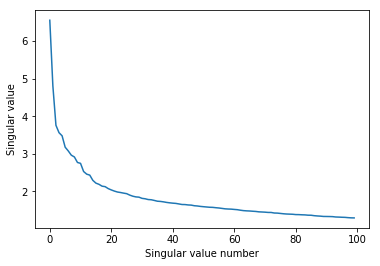

In [5]:
# We can use this graph to check how many dimensions we actually live in
_, s, _ = svds(term_doc_matrix.T, k=100)
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [6]:
tsne = TSNE(verbose=1)
words_compressed, singular_values, docs_compressed = svds(term_doc_matrix.T, k=40)
docs_compressed = docs_compressed.transpose()
projected_docs = tsne.fit_transform(docs_compressed)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 705 / 705
[t-SNE] Mean sigma: 0.086518
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.747614
[t-SNE] Error after 175 iterations: 0.747614


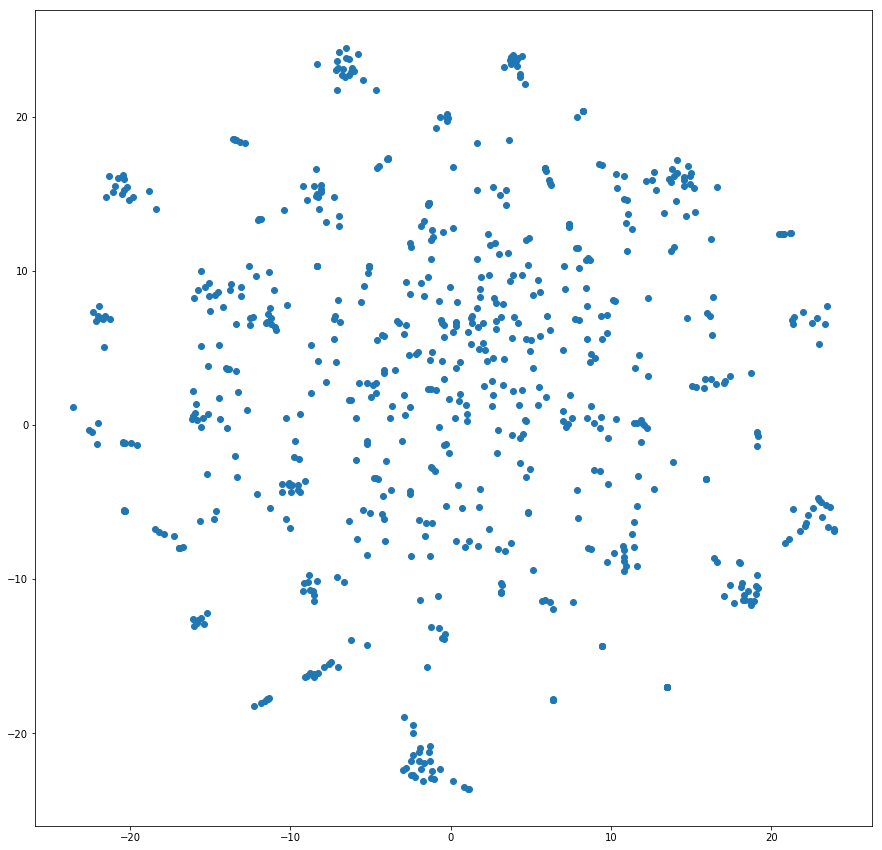

In [7]:
plt.figure(figsize=(15,15))
plt.scatter(projected_docs[:,0],projected_docs[:,1])
plt.show()

In [8]:
n_topics = 20
model = LDA(n_topics=n_topics, max_iter=10, n_jobs=4, verbose=1)
res = model.fit_transform(term_doc_matrix)

C:\Program Files\Anaconda2\envs\cs4300\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [9]:
term_doc_matrix.shape

(705, 6000)

In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [11]:
print_top_words(model, vectorizer.get_feature_names(), 20)

Topic #0:
lego payday stealth ninja restart total war counter strike miami hotline miami marvel star wars hotline wars ships shooter bullet bullet hell campaign war platformer
Topic #1:
tycoon half life alien sam doom game dev portal drones predator best best minions gta just cause source engine weapons drone park coaster gordon vice
Topic #2:
borderlands telltale walking dead batman season arkham zombies pac goo canada die die invaders ghosts cave story zombie walking episode bioshock telltale games guns
Topic #3:
puzzles puzzle puzzle game puzzle games programming platformer solve horror tis solving limbo assembly relaxing logic point click solution truck amnesia solutions puzzle platformer
Topic #4:
quake total war pets marine warhammer space marine card game war card 40k ii undead stacking scenes demand shooter marines sensitive weapons delay
Topic #5:
stronghold ball castle rts orange crusade sisters adventure mode warhammer dawn balls 40k precision isometric ps1 ve come unit burs

In [20]:
normalized_res = normalize(res)
similarities = normalized_res.dot(normalized_res.T)

In [21]:
subnautica = app_id_to_index[264710]

In [22]:
ranking = app_ids[np.argsort(similarities[subnautica, :])][::-1]

In [23]:
ranking[:10]

array([264710, 477160, 250500, 384190, 301970, 220740, 474750, 294860,
       312990, 469820])

In [16]:
similarities[subnautica, subnautica]

1.0000000000000002

In [19]:
np.linalg.norm([0])

1.0000000000000002